# Boosting and Adaboost

## Learning objectives
- implement
    - your first boosted model - Adaboost
- understand
    - the ideas behind boosting
    - how to apply boosting to decision trees and implement Adaboost

## Intro - What is boosting?

We begin by describing an algorithm called AdaBoost (Adaptive Boosting).
AdaBoost is a classification algorithm that combines a sequence of weak classifiers to repeatedly modified versions of the data, which increasingly prioritise misclassified examples. The example labels are coded as $Y \in {-1, 1}$.

Weak classifiers are those who's predictions are only slightly better than random guessing.
In this case, we use classification trees with a depth of 1.
We call such limited trees "stumps".
AdaBoost converts many "weak learners" into a single "strong learner" by combining these stumps.

AdaBoost combines the predictions of all of the classifiers to make a prediction by evaluating:
## $H(x) =  sign(\Sigma^L_{l=1} \alpha_l H_l(x)) $

This is simply the sign of a weighted combination of predictions.

### But where do the weights for each model come from?

The models are applied sequentially, and because of their limited capacity, each of them is likely to make some mistake.
For the case where each model is a stump, mistakes will be made on any dataset that is not linearly separable.

The error of a model is calculated as:
## err_l = proportion incorrect
## $err_l = \frac{\Sigma_{i=1}^m w_i I(y_i \neq H_l(x_i))}{\Sigma_{i=1}^m w_i}$

The weight of the prediction of each model is then computed based on the error rate given by:
## $ \alpha_l = \frac{1}{2} log(\frac{1-err_l}{err_l})$
# show graph of this error curve

Large negative model weight = your model sucks.
Large positive model weight = your model rocks.
Zero model weight = your model is as good as a random guessing.

Each model other than the first is trained on a dataset bootstrapped from the original.
**But the sampling of examples will be weighted.**
The weights of each example are increased if they were incorrectly classified by the previous model, and decreased if they were already classified correctly.

For the first model in the sequence, the importance of classifying each example correctly is equal.
That is, we weight the error contribution for each example in the dataset by the same equal amount, $w_i= \frac{1}{m}$.
For the next weighted sample from the dataset, 
To sample the bootstrapped dataset for the next model in the sequence to be trained on, we set the weight of each example to:
## $w_i \leftarrow w_i \cdot e^{- \alpha_l \cdot y_i H_l(x_i))}$
Let's consider what this means for a variety of cases:
- positive model weight and correct classification: weight of example pushed down
- negative model weight and correct classification: weight of example pushed up
- positive model weight and incorrect classification: weight of example pushed up
- negative model weight and incorrect classification: weight of example pushed down


### What does this weight calculation do?
Most examples may be correctly classified by our very simple weak classifier stumps.
It is the edge cases that need extra attention.
So sequentially, the importance of examples which are not able to be classified correctly by the previous model are increased and vice versa.
Models later in the sequence hence focus on harder to classify examples.
As depth increases, the importance of easy to classify examples dimishes and tends to zero.
This effectively removes them from the dataset, leaving less examples for the later models to classify.
Less examples are separable with a simpler decision boundary.

The weighting of each model prediction serves to increase the influence of models that correctly classify examples from the bootstrapped dataset which they are trained on.

# algorithm outline

![](images/boosting.jpg)

accuracy: 90.0


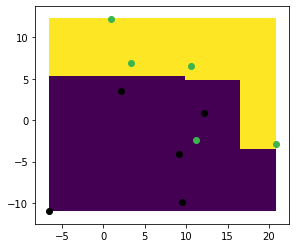

[-0.679507757133448, -0.679507757133448, 0.19379129372317094, 1.0515679367242876, -0.20342976123755235, 0.19379129372317094, -0.20342976123755235, 0.19379129372317094, -0.679507757133448, -1.0605898533359355, -0.679507757133448, -0.679507757133448, -0.4190457712942921, -0.4190457712942921, -1.0605898533359355, -0.4190457712942921, -0.679507757133448, -0.004827148122182299, -0.4190457712942921, -0.004827148122182299]


In [2]:
import sklearn.tree
from utils import get_classification_data, calc_accuracy, visualise_predictions, show_data
import numpy as np
import matplotlib.pyplot as plt
import json

class AdaBoost:
    def __init__(self, n_layers=20):
        self.n_layers = n_layers
        self.models = []

    def calc_model_error(self, predictions, labels):
        """Compute classifier error rate"""
        diff = predictions == labels
        diff = diff.astype(int)
        # weighted_diffs = weights * diff
        return np.mean(diff)

    def encode_labels(self, labels):
        labels[labels == 0] = -1
        labels[labels == 1] = +1
        return labels

    def calc_model_weight(self, error, delta=0.01):
        z = (1 - error) / (error + delta) + delta
        return 0.5 * np.log(z)

    def sample(self, X, Y, weights):
        idxs = np.random.choice(len(X), len(X), p=weights, replace=True)
        return X[idxs], Y[idxs]

    def update_weights(self, predictions, labels, model_weight):
        weights = np.exp(- model_weight * predictions * labels)
        weights /= np.sum(weights)
        return weights

    def fit(self, X, Y):
        features = X
        labels = self.encode_labels(Y)
        for layer_idx in range(self.n_layers):
            model = sklearn.tree.DecisionTreeClassifier(max_depth=1)
            model.fit(features, labels)
            self.models.append(model)
            predictions = model.predict(X)
            model_error = self.calc_model_error(predictions, labels)
            model_weight = self.calc_model_weight(model_error)
            model.weight = model_weight
            example_weights = self.update_weights(predictions, labels, model_weight)
            features, labels = self.sample(X, Y, example_weights)
            # print(f'trained model {layer_idx}')
            # print()

    def predict(self, X):
        prediction = np.zeros(len(X))
        for model in self.models:
            prediction += -model.weight * model.predict(X)
        return np.sign(prediction)

    def __repr__(self):
        return json.dumps([m.weight for m in self.models])
        return json.dumps([
            {
                'weight': model.weight
            }
            for model in self.models
        ], indent=4)

X, Y = get_classification_data()
adaBoost = AdaBoost()
adaBoost.fit(X, Y)
predictions = adaBoost.predict(X)
print(f'accuracy: {calc_accuracy(predictions, Y)}')
visualise_predictions(adaBoost.predict, X)
show_data(X, Y)
print(adaBoost)

model 0
accuracy: 75.0
weights: [-0.54, -0.08, -0.1, -0.0, 0.01, 0.13, -0.04, 0.05, -0.06, -0.14, -0.1, 0.03, -0.1, -0.06, 0.01, 0.05, 0.05, 0.07, -0.0, 0.11]


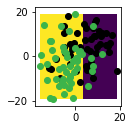


model 1
accuracy: 75.0
weights: [-0.54, -0.06, -0.08, -0.02, -0.12, -0.04, -0.08, 0.03, 0.05, 0.05, 0.03, 0.01, 0.01, -0.0, -0.1, 0.19, 0.05, 0.01, 0.13, 0.01]


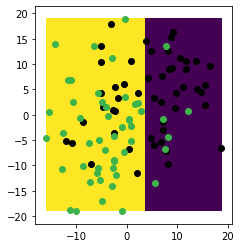


model 2
accuracy: 75.0
weights: [-0.54, 0.07, -0.12, -0.04, -0.04, 0.21, -0.1, 0.13, 0.01, 0.07, -0.06, -0.14, -0.0, -0.1, -0.04, -0.24, -0.02, -0.14, 0.01, 0.07]


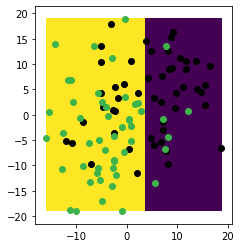


model 3
accuracy: 27.0
weights: [-0.54, -0.02, -0.02, 0.01, -0.02, 0.09, 0.09, 0.03, -0.0, 0.07, 0.05, 0.15, 0.07, -0.0, -0.06, 0.09, 0.07, 0.11, 0.03, 0.01]


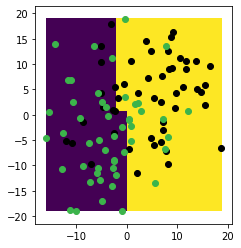


model 4
accuracy: 75.0
weights: [-0.54, 0.01, -0.08, 0.07, -0.02, -0.16, 0.07, -0.04, -0.12, -0.14, -0.1, -0.04, -0.04, 0.05, -0.14, -0.04, 0.05, -0.18, -0.02, -0.14]


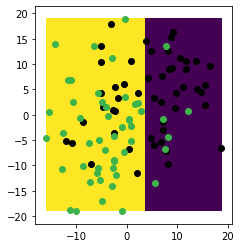


model 5
accuracy: 75.0
weights: [-0.54, -0.12, -0.0, -0.12, 0.05, 0.13, -0.08, -0.0, -0.02, -0.16, 0.05, 0.19, -0.14, -0.0, 0.01, -0.06, -0.02, 0.01, -0.1, 0.01]


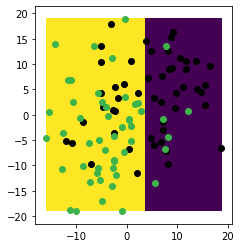


model 6
accuracy: 75.0
weights: [-0.54, -0.06, -0.1, 0.03, -0.0, -0.1, 0.01, -0.04, -0.02, 0.05, 0.19, -0.24, 0.09, -0.08, -0.12, 0.03, -0.1, 0.07, -0.02, -0.0]


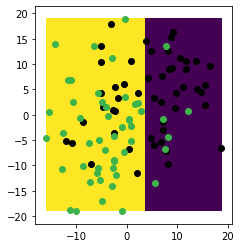


model 7
accuracy: 73.0
weights: [-0.54, 0.01, -0.06, -0.04, 0.09, 0.01, -0.04, 0.03, 0.07, -0.02, -0.04, 0.03, -0.02, -0.08, 0.19, -0.06, -0.24, 0.09, -0.27, 0.03]


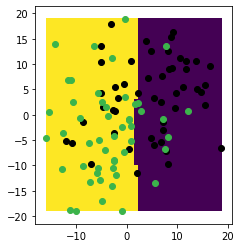


model 8
accuracy: 75.0
weights: [-0.54, -0.29, -0.12, 0.17, 0.05, -0.08, 0.03, -0.14, 0.03, -0.08, -0.06, 0.01, 0.19, 0.07, 0.13, -0.0, -0.16, -0.14, 0.01, 0.07]


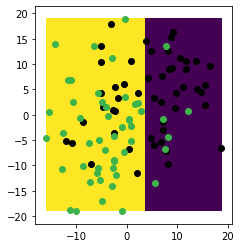


model 9
accuracy: 75.0
weights: [-0.54, -0.08, 0.09, 0.07, -0.04, -0.02, 0.03, -0.02, 0.03, -0.1, 0.01, -0.02, -0.18, -0.1, 0.07, -0.08, 0.13, -0.0, -0.0, -0.02]


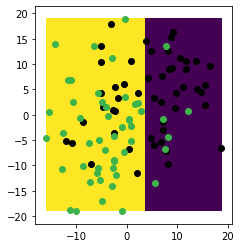


model 10
accuracy: 75.0
weights: [-0.54, 0.07, -0.06, -0.08, -0.02, -0.12, 0.19, 0.09, -0.08, -0.02, -0.0, -0.02, 0.01, 0.03, -0.0, -0.12, -0.12, 0.03, 0.13, 0.05]


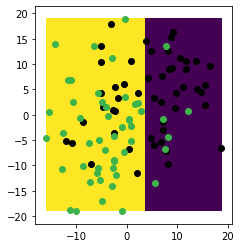


model 11
accuracy: 75.0
weights: [-0.54, -0.29, -0.08, -0.04, 0.07, -0.0, -0.1, 0.07, -0.02, -0.08, -0.24, 0.15, -0.04, -0.04, 0.07, -0.0, -0.06, 0.05, -0.02, 0.01]


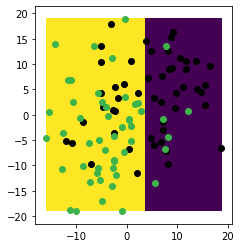


model 12
accuracy: 73.0
weights: [-0.54, -0.04, 0.13, -0.0, -0.1, 0.07, 0.13, 0.07, -0.02, -0.08, 0.09, 0.13, -0.12, -0.02, 0.07, 0.13, -0.04, -0.06, 0.03, 0.05]


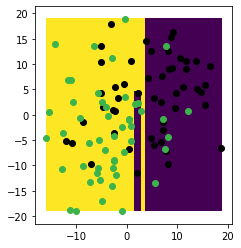


model 13
accuracy: 75.0
weights: [-0.54, -0.12, 0.11, -0.1, 0.17, 0.09, 0.07, 0.03, -0.0, -0.02, -0.0, -0.1, 0.09, -0.06, 0.05, -0.04, -0.06, 0.17, -0.0, 0.05]


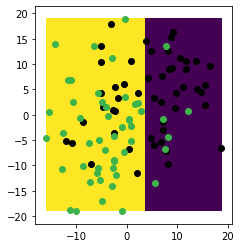


model 14
accuracy: 75.0
weights: [-0.54, 0.03, -0.0, -0.06, -0.0, -0.16, -0.02, -0.06, 0.05, 0.03, 0.01, -0.08, 0.11, -0.06, 0.11, -0.14, -0.14, -0.16, 0.03, 0.09]


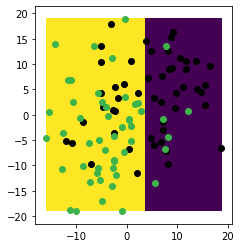


model 15
accuracy: 75.0
weights: [-0.54, -0.1, -0.16, -0.1, 0.19, 0.11, 0.07, -0.02, 0.01, 0.07, 0.11, -0.0, -0.0, 0.15, -0.0, -0.12, -0.1, 0.17, -0.04, -0.06]


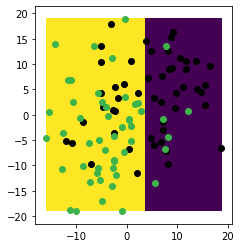


model 16
accuracy: 75.0
weights: [-0.54, 0.05, 0.01, 0.03, -0.1, -0.06, 0.13, -0.02, -0.12, 0.15, -0.12, -0.0, -0.16, 0.01, -0.08, -0.0, 0.07, -0.12, -0.08, 0.01]


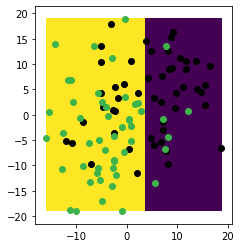


model 17
accuracy: 75.0
weights: [-0.54, -0.14, 0.05, -0.06, -0.08, 0.03, 0.15, -0.0, -0.0, -0.0, 0.13, 0.03, -0.04, 0.13, 0.11, 0.17, -0.18, -0.1, -0.1, 0.09]


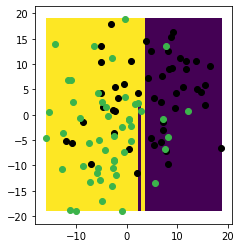


model 18
accuracy: 72.0
weights: [-0.54, 0.19, -0.12, 0.05, -0.1, 0.05, -0.06, -0.0, 0.05, 0.15, 0.13, 0.05, -0.06, -0.14, 0.03, -0.2, -0.08, 0.07, 0.01, -0.02]


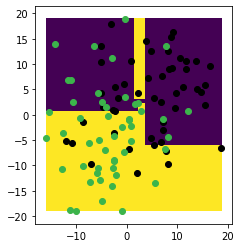


model 19
accuracy: 75.0
weights: [-0.54, -0.0, 0.11, 0.11, -0.1, -0.1, 0.05, 0.11, 0.15, 0.07, -0.04, 0.01, -0.1, -0.06, 0.01, -0.06, -0.04, 0.01, 0.03, -0.02]


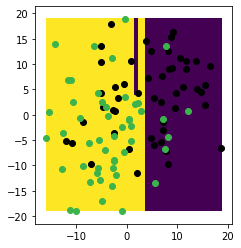

In [3]:
fig = plt.figure()
fig.add_subplot(211)
X, Y = get_classification_data(sd=8, m=100)

for i in range(20):
    adaBoost = AdaBoost()
    adaBoost.fit(X, Y)
    predictions = adaBoost.predict(X)
    print(f'model {i}')
    print(f'accuracy: {calc_accuracy(predictions, Y)}')
    print(f'weights: {[ round(m.weight, 2) for m in adaBoost.models]}')
    visualise_predictions(adaBoost.predict, X)
    show_data(X, Y)
    print()

## Sklearn implementation

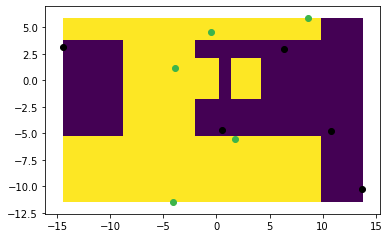

In [12]:
import sklearn.ensemble

adaBoost = sklearn.ensemble.AdaBoostClassifier()
adaBoost.fit(X, Y)
predictions = adaBoost.predict(X)
calc_accuracy(predictions, Y)
visualise_predictions(adaBoost.predict, X)
show_data(X, Y)

## Let's visualise our predictions

Firstly visualise the predictions for each classifier, then visualise their successive combination.

## How can we boost other models?

## Challenges
- perform adaptive boosting with a model that is not a decision tree
- adapt the above code to work for a regression model